# Librerias

In [1]:
import os
import zipfile

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import string

import tensorflow as tf
import logging

# Establece el nivel de log de TensorFlow a 'ERROR'
tf.get_logger().setLevel('ERROR')

# Si utilizas XLA, puedes ajustar el nivel de log de XLA también
tf.debugging.set_log_device_placement(False)

def check_gpu():
    # Verifica si TensorFlow puede detectar GPUs
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("TensorFlow detectó las siguientes GPUs:")
        for gpu in gpus:
            print(f"- {gpu.name}")
            # Obtiene información adicional sobre la GPU
            details = tf.config.experimental.get_device_details(gpu)
            print(f"  - Nombre: {details.get('device_name', 'Desconocido')}")
    else:
        print("No se detectaron GPUs. Verifica la configuración de CUDA y cuDNN.")

if __name__ == "__main__":
    check_gpu()

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-08-16 12:59:10.989720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 12:59:11.050224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 12:59:11.067523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 12:59:11.180574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 12:59:12.169931: W tensorflow/compiler/tf2

TensorFlow detectó las siguientes GPUs:
- /physical_device:GPU:0
  - Nombre: NVIDIA GeForce RTX 4060 Laptop GPU


I0000 00:00:1723831152.721446   15750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723831152.847340   15750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723831152.847560   15750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723831152.848142   15750 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Data

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/platzi-tf2/sign-language-img.zip -O /tmp/sign-language-img.zip

--2024-08-16 12:59:13--  https://storage.googleapis.com/platzi-tf2/sign-language-img.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.78.91, 142.250.78.59, 142.250.78.123, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.78.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24265584 (23M) [application/zip]
Saving to: ‘/tmp/sign-language-img.zip’

/tmp/sign-language- 100%[===================>]  23.14M  12.4MB/s    in 1.9s    

2024-08-16 12:59:15 (12.4 MB/s) - ‘/tmp/sign-language-img.zip’ saved [24265584/24265584]



In [3]:
local_zip = '/tmp/sign-language-img.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/sign-language-img')
zip_ref.close()

In [4]:
train_dir = '/tmp/sign-language-img/Train'
test_dir = '/tmp/sign-language-img/Test'

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(28, 28),
    batch_size=128,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 27455 images belonging to 24 classes.
Found 1425 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


Recuerde que en lenguaje de se;as la J y la Z tienen movimiento, entonces las descartamos del analisis.

In [7]:
classes = [char for char in string.ascii_uppercase if char not in ['J', 'Z']]
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

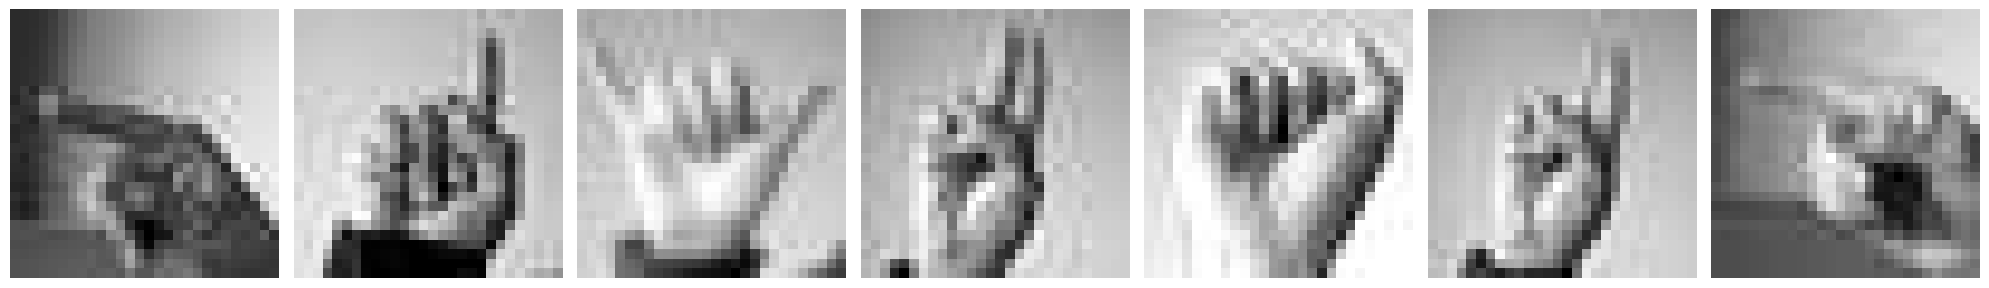

In [8]:
def PlotImages(images_arr):
    fig, axes = plt.subplots(1, 7, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:, :, 0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_generator)
PlotImages(sample_training_images[:7])


# Modelo base

In [9]:
modelo_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

modelo_base.summary()

modelo_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/riemannintegrable/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1723831158.770812   15750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723831158.771102   15750 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723831158.771313   15750 cuda_executor.cc:1015] successful

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# hist_base = modelo_base.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20


/home/riemannintegrable/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723831159.646448   23534 service.cc:146] XLA service 0x7e0c88009220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723831159.646484   23534 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-08-16 12:59:19.685374: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-16 12:59:19.816933: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded 

 14/215 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.0543 - loss: 3.2739

I0000 00:00:1723831162.799318   23534 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


126/215 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1543 - loss: 2.8996

2024-08-16 12:59:26.058183: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_327', 428 bytes spill stores, 428 bytes spill loads

2024-08-16 12:59:26.300019: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_327', 444 bytes spill stores, 444 bytes spill loads



215/215 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.2187 - loss: 2.6641 - val_accuracy: 0.5200 - val_loss: 1.6000
Epoch 2/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5995 - loss: 1.3370 - val_accuracy: 0.5656 - val_loss: 1.3595
Epoch 3/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7157 - loss: 0.9324 - val_accuracy: 0.6470 - val_loss: 1.1475
Epoch 4/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7866 - loss: 0.7102 - val_accuracy: 0.6491 - val_loss: 1.0705
Epoch 5/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8439 - loss: 0.5392 - val_accuracy: 0.6877 - val_loss: 1.0101
Epoch 6/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8857 - loss: 0.4046 - val_accuracy: 0.7200 - val_loss: 1.0231
Epoch 7/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9152 - loss: 0.3087 - val_accuracy: 0.6919 - val_loss: 1.0174
Epoch 8/20
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9384 - loss: 0.2369 - val_accuracy: 0.71

In [11]:
def visualizacion_resultados(hist, epochs):
    
    train_acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    train_loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(range(epochs), train_acc, label='Train Accuracy')
    ax[0].plot(range(epochs), val_acc, label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()
    ax[1].plot(range(epochs), train_loss, label='Train Loss')
    ax[1].plot(range(epochs), val_loss, label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()

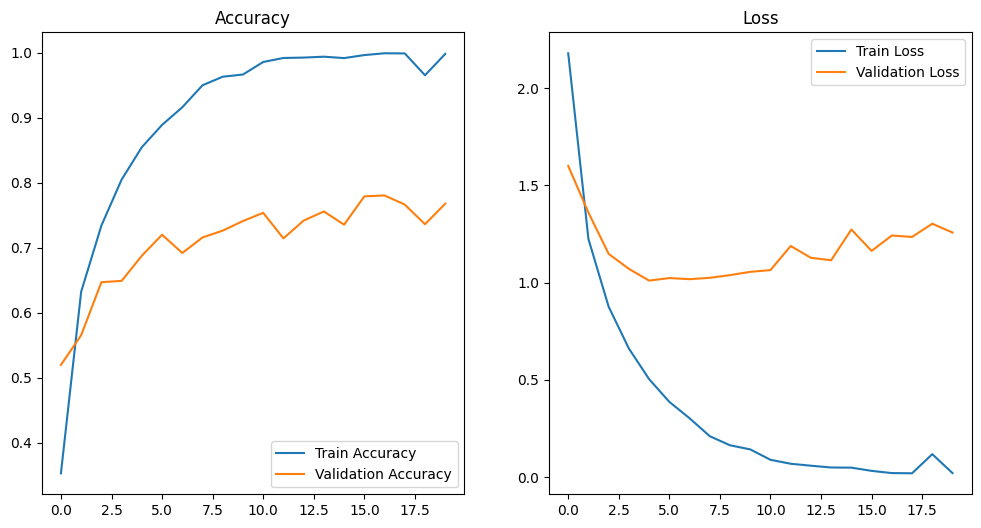

In [12]:
visualizacion_resultados(hist_base, 20)

vaya caca de red xdxd

# Modelo 2

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 236,952 (925.59 KB)

 Trainable params: 236,952 (925.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.1406 - loss: 2.8794 - val_accuracy: 0.5123 - val_loss: 1.7177
Epoch 2/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4657 - loss: 1.6518 - val_accuracy: 0.5789 - val_loss: 1.3797
Epoch 3/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6029 - loss: 1.1997 - val_accuracy: 0.6330 - val_loss: 1.1348
Epoch 4/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6791 - loss: 0.9721 - val_accuracy: 0.6863 - val_loss: 1.0270
Epoch 5/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7380 - loss: 0.7933 - val_accuracy: 0.6828 - val_loss: 0.9391
Epoch 6/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7760 - loss: 0.6721 - val_accuracy: 0.6975 - val_loss: 0.9479
Epoch 7/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8173 - loss: 0.5603 - val_accuracy: 0.7361 - val_loss: 0.8163
Epoch 8/30
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8318 - loss: 0.4926 - val_accu

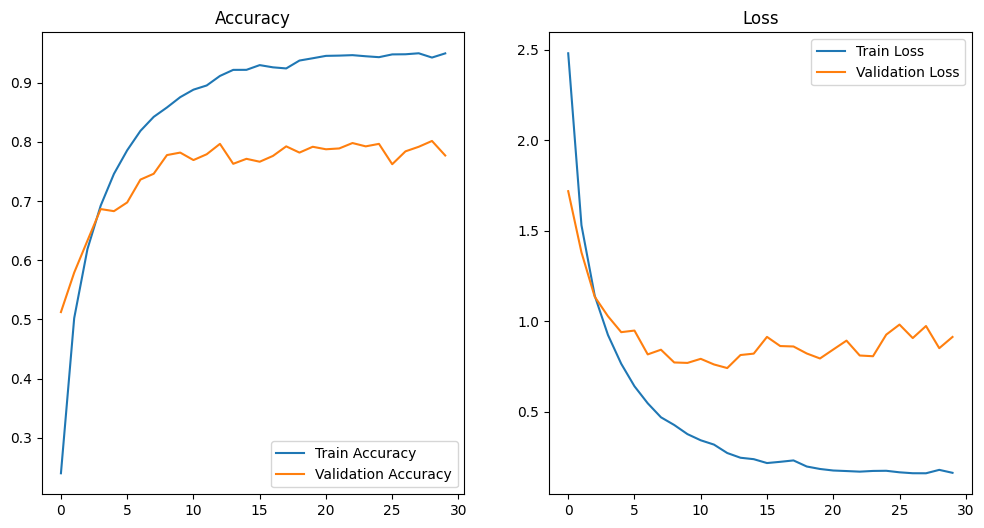

In [13]:
modelo_2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])

modelo_2.summary()

modelo_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist_2 = modelo_2.fit(train_generator, epochs=30, validation_data=validation_generator)

visualizacion_resultados(hist_2, 30)

# Modelo 3

/home/riemannintegrable/anaconda3/envs/dsenv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │       301,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,280 (1.22 MB)

 Trainable params: 320,088 (1.22 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
210/215 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7944 - loss: 0.9478
Epoch 1: val_accuracy improved from -inf to 0.06737, saving model to godin.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7984 - loss: 0.9293 - val_accuracy: 0.0674 - val_loss: 4.1723
Epoch 2/50
211/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0100
Epoch 2: val_accuracy improved from 0.06737 to 0.35298, saving model to godin.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.3530 - val_loss: 2.1206
Epoch 3/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0085
Epoch 3: val_accuracy improved from 0.35298 to 0.84772, saving model to godin.weights.h5
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 1.0000 - loss: 0.0085 - val_accuracy: 0.8477 - val_loss: 0.5363
Epoch 4/50
214/215 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0078
Epoch 4: val_accuracy improved fro

[0.540196418762207, 0.8862242102622986]

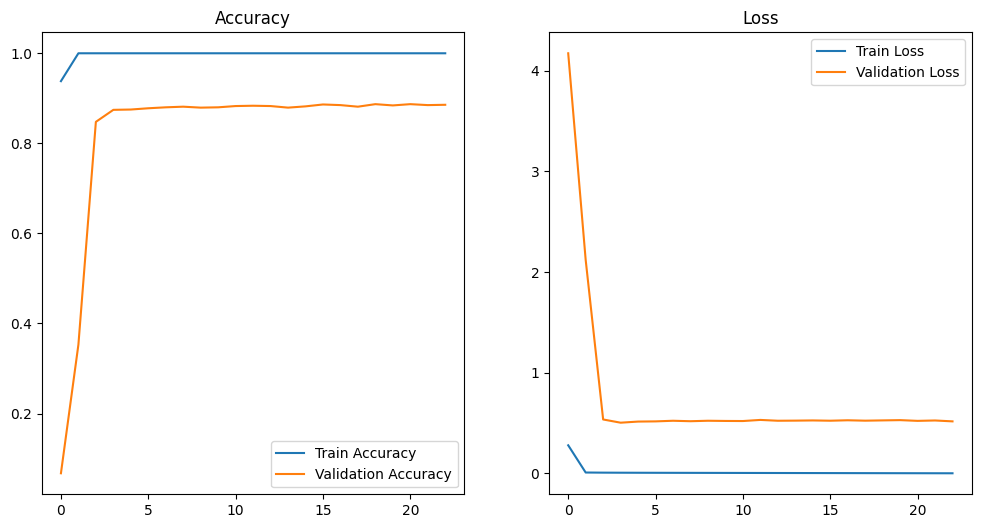

In [16]:
early = EarlyStopping(monitor='val_accuracy', patience=4)
mejor = ModelCheckpoint('godin.weights.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Creando modelo 3
modelo_3 = tf.keras.models.Sequential()

# Añadir la primera capa convolucional
modelo_3.add(Conv2D(32, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l1(1e-5), input_shape=(28,28,1)))
modelo_3.add(Activation('relu'))
modelo_3.add(BatchNormalization())

# Añadir la segunda capa convolucional
modelo_3.add(Conv2D(64, kernel_size=(3,3), padding='same', kernel_regularizer=regularizers.l1(1e-5)))
modelo_3.add(Activation('relu'))
modelo_3.add(MaxPooling2D(pool_size=(2,2)))
modelo_3.add(BatchNormalization())

# Añadir la capa de Flatten 
modelo_3.add(Flatten())
modelo_3.add(Dense(24, activation='softmax'))

modelo_3.summary()

modelo_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist_3 = modelo_3.fit(train_generator, batch_size=512, epochs=50, validation_data=validation_generator, callbacks=[early, mejor])

visualizacion_resultados(hist_3, len(hist_3.epoch))

modeo_3 = modelo_3.load_weights('godin.weights.h5')

modelo_3.evaluate(test_generator)